### Imports

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import keras
import pickle
import time
import tensorflow as tf
from scipy.spatial import distance
from matplotlib import pyplot as plt
import random
import shutil

Using TensorFlow backend.


### Functions

In [2]:
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

### Variables

In [3]:
name = 'Adri'
number = '01'

In [4]:
#Loading NN model weights
model = keras.models.load_model('../../models/Final_experiments/Experiment_07/model_13,70_mpjpe.h5')
#Loading scaler weights
scaler = pickle.load(open('../../models/Final_experiments/Experiment_07/scaler_13,70_mpjpe.pkl','rb'))

In [5]:
mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

#Loading 2D MOCAP test data --> The one that will be ingested in the trained model
df_2D_raw = pd.read_csv('../../../MOCAP/data_export_1/Kinect/'+name+'/'+name+number+'/filtered_csv/2d_TIMECODE_'+name+number+'.csv')
#Loading 3D MOCAP test data --> Will serve as the ground truth for comparing predicted 3D keypoints
df_3D_raw = pd.read_csv('../../../MOCAP/data_export_1/Kinect/'+name+'/'+name+number+'/filtered_csv/3d_TIMECODE_'+name+number+'.csv')


gt_df_2D = pd.DataFrame(columns=list(df_2D_raw))
gt_df_3D = pd.DataFrame(columns=list(df_3D_raw))

for filename in glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/'+name+'/*.jpg'):
    frame_timecode = (round(float(filename.split('\\')[-1].split('.jpg')[0].split('_')[-1]),3))
    gt_df_2D = gt_df_2D.append(df_2D_raw[df_2D_raw['timecode']==df_2D_raw[df_2D_raw['timecode']<frame_timecode]['timecode'].max()])
    gt_df_3D = gt_df_3D.append(df_3D_raw[df_3D_raw['timecode']==df_3D_raw[df_3D_raw['timecode']<frame_timecode]['timecode'].max()])
    


#Just cleaning corrected03
gt_df_2D = gt_df_2D.drop(columns=['timecode'])
gt_df_3D = gt_df_3D.drop(columns=['timecode'])
#Nose porque Quique manda el orden girado
gt_df_3D = gt_df_3D[['RightShoulder',
 'RightShoulder.1',
 'RightShoulder.2',
 'RightElbow',
 'RightElbow.1',
 'RightElbow.2',
 'RightHand',
 'RightHand.1',
 'RightHand.2',
 'LeftShoulder',
 'LeftShoulder.1',
 'LeftShoulder.2',
 'LeftElbow',
 'LeftElbow.1',
 'LeftElbow.2',
 'LeftHand',
 'LeftHand.1',
 'LeftHand.2']]

In [6]:
gt_df_3D

,RightShoulder,RightShoulder.1,RightShoulder.2,RightElbow,RightElbow.1,RightElbow.2,RightHand,RightHand.1,RightHand.2,LeftShoulder,LeftShoulder.1,LeftShoulder.2,LeftElbow,LeftElbow.1,LeftElbow.2,LeftHand,LeftHand.1,LeftHand.2
0,-0.232,0.104,1.192,-0.434,-0.030,1.378,-0.394,-0.165,1.147,0.133,0.142,1.191,0.324,0.001,1.383,0.291,-0.158,1.166
1,-0.231,0.106,1.201,-0.434,-0.034,1.380,-0.394,-0.165,1.146,0.135,0.142,1.203,0.323,-0.006,1.391,0.289,-0.158,1.170
2,-0.230,0.107,1.209,-0.434,-0.037,1.383,-0.394,-0.165,1.148,0.137,0.141,1.214,0.321,-0.015,1.401,0.288,-0.158,1.173
3,-0.228,0.109,1.216,-0.434,-0.039,1.385,-0.395,-0.165,1.149,0.139,0.140,1.227,0.319,-0.027,1.409,0.285,-0.157,1.174
4,-0.226,0.110,1.221,-0.433,-0.041,1.386,-0.395,-0.164,1.148,0.142,0.137,1.238,0.316,-0.041,1.414,0.277,-0.156,1.172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,-0.183,0.062,1.112,-0.375,-0.170,1.069,-0.204,-0.270,0.884,0.199,0.068,1.171,0.307,-0.208,1.240,0.120,-0.243,1.048
693,-0.183,0.064,1.120,-0.379,-0.169,1.097,-0.213,-0.265,0.906,0.198,0.068,1.170,0.307,-0.208,1.239,0.119,-0.242,1.048
694,-0.184,0.066,1.128,-0.380,-0.168,1.126,-0.220,-0.260,0.929,0.198,0.069,1.170,0.308,-0.208,1.239,0.119,-0.242,1.048
695,-0.184,0.067,1.136,-0.380,-0.167,1.157,-0.225,-0.255,0.953,0.198,0.069,1.169,0.308,-0.207,1.238,0.119,-0.242,1.047


### Preprocessing

In [7]:
X = np.array(gt_df_2D).astype(float)
y = np.array(gt_df_3D).astype(float)
print(X.shape)
print(y.shape)

(422, 12)
(422, 18)


In [8]:
#Standarization
X_scaled = scaler.transform(X)

In [9]:
#NN inference
z_predicted = model.predict(X_scaled)

#Splitting into packs of 3 coordinates
df_pred_3d = pd.DataFrame(split_3_coordinates(z_predicted))
df_gt_3d = pd.DataFrame(split_3_coordinates(y))
df_pred_3d = df_pred_3d.rename(columns=mapping_numbers_variables)
df_gt_3d = df_gt_3d.rename(columns=mapping_numbers_variables)

In [10]:
df_pred_3d.head(5)

,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist
0,"[-0.20502424, 0.10319386, 1.2127601]","[-0.40823993, -0.047428243, 1.4178641]","[-0.38256687, -0.19167641, 1.2015377]","[0.15773803, 0.14587036, 1.20375]","[0.35685366, -0.02406253, 1.4116898]","[0.32491082, -0.19029681, 1.2041023]"
1,"[-0.20237902, 0.10452512, 1.2194079]","[-0.40635663, -0.052462056, 1.4191504]","[-0.38120127, -0.19164519, 1.2008662]","[0.15971634, 0.1457226, 1.213966]","[0.3556433, -0.03130243, 1.4164246]","[0.32385394, -0.19012956, 1.2048817]"
2,"[-0.19922939, 0.10605167, 1.2252787]","[-0.40300786, -0.055789113, 1.419827]","[-0.37930012, -0.19144864, 1.2002461]","[0.1621823, 0.14404327, 1.223836]","[0.35404977, -0.03973043, 1.4213722]","[0.32283756, -0.18950753, 1.2057331]"
3,"[-0.19594479, 0.10718808, 1.2314126]","[-0.4000032, -0.05828005, 1.4198246]","[-0.3776912, -0.1911344, 1.199039]","[0.16479069, 0.14164291, 1.2339138]","[0.35140944, -0.05009824, 1.4258368]","[0.31913587, -0.18893686, 1.2058388]"
4,"[-0.19311321, 0.10825289, 1.2388495]","[-0.39859477, -0.060790315, 1.4190451]","[-0.37735623, -0.19018987, 1.1967089]","[0.16723056, 0.13886793, 1.2451595]","[0.34798703, -0.06305224, 1.4289265]","[0.31084844, -0.18816757, 1.204257]"


In [11]:
df_gt_3d.head(5)

,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist
0,"[-0.232, 0.104, 1.192]","[-0.434, -0.03, 1.378]","[-0.394, -0.165, 1.147]","[0.133, 0.142, 1.191]","[0.324, 0.001, 1.383]","[0.291, -0.158, 1.166]"
1,"[-0.231, 0.106, 1.201]","[-0.434, -0.034, 1.38]","[-0.394, -0.165, 1.146]","[0.135, 0.142, 1.203]","[0.323, -0.006, 1.391]","[0.289, -0.158, 1.17]"
2,"[-0.23, 0.107, 1.209]","[-0.434, -0.037, 1.383]","[-0.394, -0.165, 1.148]","[0.137, 0.141, 1.214]","[0.321, -0.015, 1.401]","[0.288, -0.158, 1.173]"
3,"[-0.228, 0.109, 1.216]","[-0.434, -0.039, 1.385]","[-0.395, -0.165, 1.149]","[0.139, 0.14, 1.227]","[0.319, -0.027, 1.409]","[0.285, -0.157, 1.174]"
4,"[-0.226, 0.11, 1.221]","[-0.433, -0.041, 1.386]","[-0.395, -0.164, 1.148]","[0.142, 0.137, 1.238]","[0.316, -0.041, 1.414]","[0.277, -0.156, 1.172]"


### Metrics MPJPE

In [12]:
#Compute the euclidean distances of each 3D predicted keypoint vs the ground truth and generate a dataframe with the results.
all_distances = []
for keypoint in list(mapping_numbers_variables.values()):
    keypoint_distances = []
    for i in range(0,len(df_gt_3d[keypoint])):
        keypoint_distances.append(distance.euclidean(df_gt_3d[keypoint][i], df_pred_3d[keypoint][i]))
    all_distances.append(keypoint_distances)
df_PJPE = pd.DataFrame(all_distances).T.rename(columns=mapping_numbers_variables)

#Per joint position error dataframe euclidean distance in [mm]
(df_PJPE*1000).head(5)

,right_shoulder,right_elbow,right_wrist,left_shoulder,left_elbow,left_wrist
0,34.048829,50.561547,61.779536,28.098268,50.305028,60.372274
1,34.061522,51.359063,62.322356,27.294844,48.499588,58.854369
2,34.824230,51.669817,60.376086,27.205801,46.031588,57.252365
3,35.614176,52.347454,59.046596,26.751807,43.213170,56.559085
4,37.459296,51.646439,58.049724,26.293135,41.620553,56.753720


In [13]:
means = []
for column in list(df_PJPE.columns):
    means.append(df_PJPE[column].mean())
    
mpjpe = sum(means)/len(df_PJPE.columns)
print('The obtained MPJPE error is: '+'\033[1m'+str(mpjpe*1000)+'mm')

The obtained MPJPE error is: 11.606839139294163mm


([<matplotlib.axis.XTick at 0x228a16db708>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

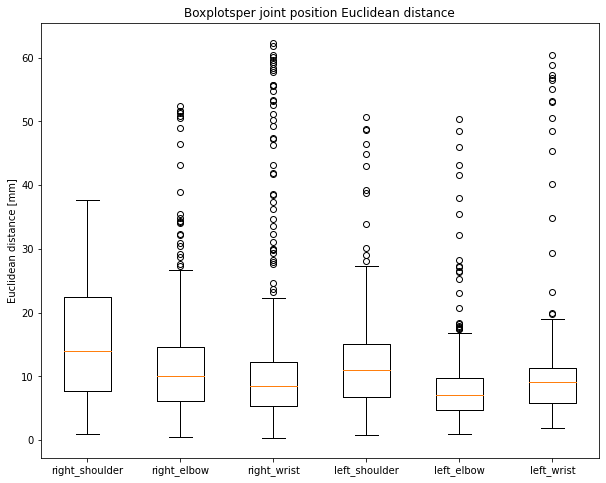

In [14]:
fig = plt.figure(figsize=(10,8))
plt.boxplot(df_PJPE*1000)
plt.title('Boxplotsper joint position Euclidean distance')
plt.ylabel('Euclidean distance [mm]')
#plt.ylim([0,80])
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)

In [15]:
df_PJPE.mean()*1000

right_shoulder    15.301737
right_elbow       11.808740
right_wrist       12.063447
left_shoulder     12.107134
left_elbow         8.302180
left_wrist        10.057797
dtype: float64

### Visualization of 3D predicted keypoints and GroundTruth ones

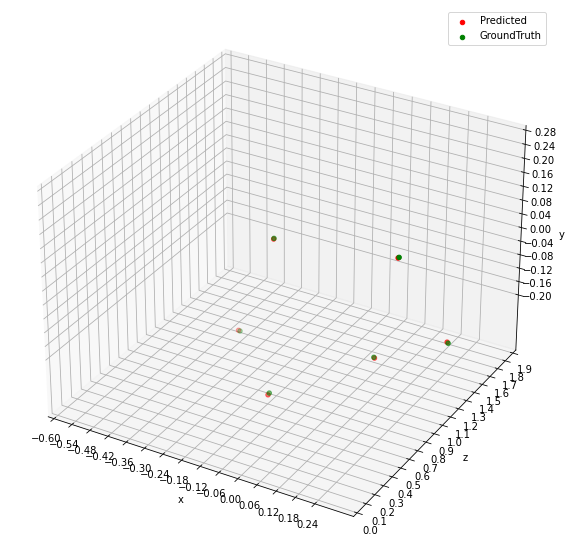

In [22]:
index = random.randint(0,len(glob('../../../MOCAP/data_final_analysis/Frames_to_analyze/Adri/*.jpg')))

x_line = []
y_line = []
z_line = []

for keypoint in list(df_pred_3d.iloc[index]):
    x_line.append(keypoint[0])
    y_line.append(keypoint[1])
    z_line.append(keypoint[2])
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

x_line2 = []
y_line2 = []
z_line2 = []

for keypoint in list(df_gt_3d.iloc[index]):
    x_line2.append(keypoint[0])
    y_line2.append(keypoint[1])
    z_line2.append(keypoint[2])
    



ax.scatter(x_line, z_line,y_line,c='red',label='Predicted')
ax.scatter(x_line2, z_line2,y_line2,c='green',label='GroundTruth')

ax.set_xticks(np.arange(-0.6,0.3,0.06))
ax.set_xlabel('x')
ax.set_yticks(np.arange(0,2.0,0.1))
ax.set_ylabel('z')
ax.set_zticks(np.arange(-0.2,0.3,0.04))
ax.set_zlabel('y')
#ax.set_title('Predicted 3D coordinates')
ax.legend()

### Outlier analysis

In [50]:
number_keypoints_to_detect = 6

In [51]:
df_PJPE_mm = df_PJPE*1000
q3_list = list(df_PJPE_mm.quantile(0.75))
q1_list = list(df_PJPE_mm.quantile(0.25))
iqr_list = list(np.array(q3_list)-np.array(q1_list))
maximum_values_list = np.array(q3_list) + 1.5*np.array(iqr_list)
max_values_dict = dict(zip(mapping_numbers_variables.values(),maximum_values_list))

In [58]:
q3_list = list(df_PJPE_mm.quantile(0.75))
q1_list = list(df_PJPE_mm.quantile(0.25))
iqr_list = list(np.array(q3_list)-np.array(q1_list))
maximum_values_list = np.array(q3_list) + 1.5*np.array(iqr_list)
max_values_dict = dict(zip(mapping_numbers_variables.values(),maximum_values_list))

#How many outliers there are per each keypoint?

df_outliers = pd.DataFrame(columns = np.arange(0,number_keypoints_to_detect)+1)
mapping_numbers_variables[6] = 'outlier'
df_outliers = df_outliers.rename(columns=mapping_numbers_variables)

for keypoint in max_values_dict.keys():
    outliers = df_PJPE_mm[df_PJPE_mm[keypoint] >  max_values_dict.get(keypoint)]
    outliers['outlier'] = keypoint
    
    df_outliers = df_outliers.append(outliers)
    print('There are '+str(len(outliers))+' outliers for keypoint: '+str(keypoint))

df_outliers = df_outliers[['right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist','outlier']]
index_outlier_per_keypoint = {}
keypoint_outliers = df_outliers.groupby('outlier')
keypoints = ['right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist']
for keypoint in keypoints:
    index_outlier_per_keypoint[keypoint] = list(keypoint_outliers.groups[keypoint])

There are 7 outliers for keypoint: right_shoulder
There are 0 outliers for keypoint: right_elbow
There are 0 outliers for keypoint: right_wrist
There are 0 outliers for keypoint: left_shoulder
There are 9 outliers for keypoint: left_elbow
There are 6 outliers for keypoint: left_wrist


KeyError: 'right_elbow'